# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tensorflow-io matplotlib

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [2]:
tf.__version__

'2.6.2'

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [3]:
CAPUCHIN_FILE = os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [4]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [5]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

2023-02-08 06:52:41.634915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 06:52:41.645763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 06:52:41.646590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 06:52:41.648308: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

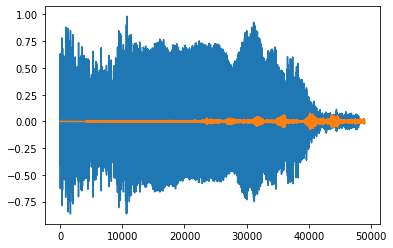

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

## 3.2 Create Tensorflow Datasets

In [7]:
pos = tf.data.Dataset.list_files('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/*')

neg = tf.data.Dataset.list_files('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/*')


## 3.3 Add labels and Combine Positive and Negative Samples

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [9]:
lengths = []
for file in os.listdir(os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [10]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [11]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [12]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [13]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [14]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [15]:
spectrogram, label = preprocess(filepath, label)

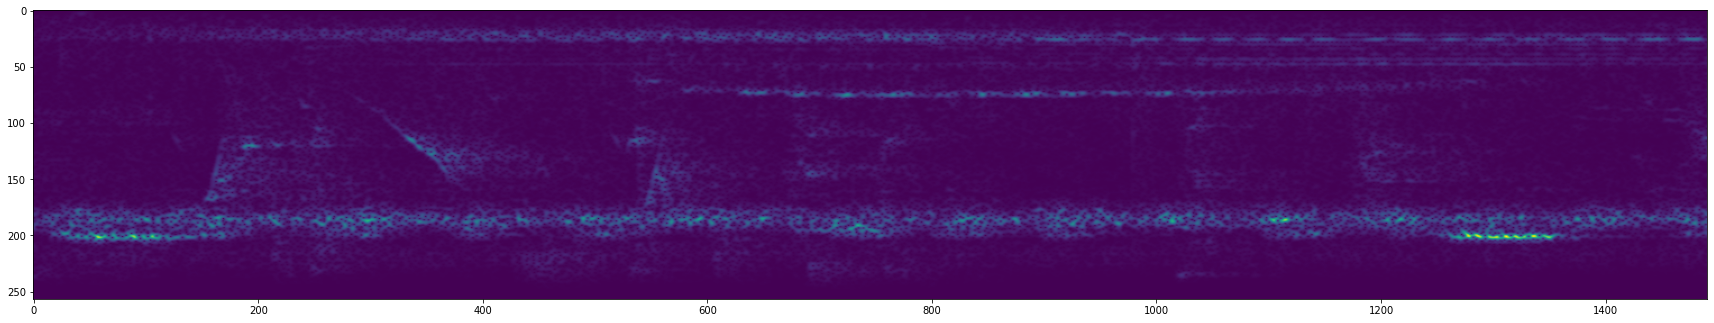

In [16]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [17]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

2023-02-08 06:52:52.460898: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


In [18]:
spectrogram, label = preprocess(filepath, label)

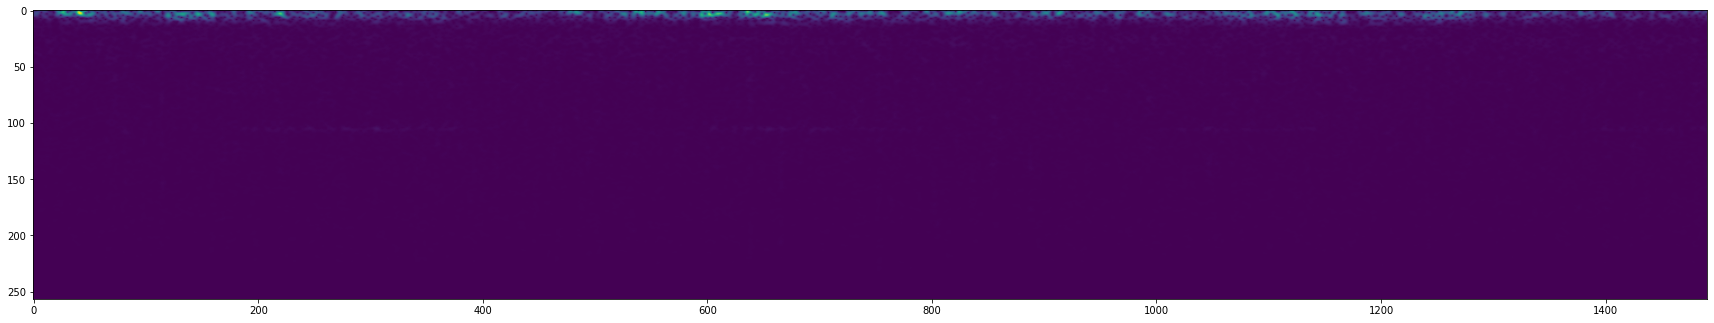

In [19]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [20]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [21]:
len(data)

51

In [22]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [23]:
samples, labels = train.as_numpy_iterator().next()

2023-02-08 06:53:03.552407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 205 of 1000
2023-02-08 06:53:13.534342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 413 of 1000
2023-02-08 06:53:23.473752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 620 of 1000
2023-02-08 06:53:33.283805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


In [24]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras import layers

## 7.2 Build Sequential Model, Compile and View Summary

In [26]:
norm_layer = layers.Normalization()
cnn_model = Sequential([
    layers.Input(shape=(1491, 257,1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1,activation='sigmoid'),
])

In [27]:
cnn_model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [28]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## 7.3 Fit Model, View Loss and KPI Plots

In [29]:
hist = cnn_model.fit(train, epochs=8, validation_data=test)

Epoch 1/8


2023-02-08 06:54:08.304803: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - 3s 39ms/step - loss: 0.2833 - recall: 0.7469 - precision: 0.8013 - val_loss: 0.1016 - val_recall: 0.8269 - val_precision: 1.0000
Epoch 2/8
36/36 [==============================] - 1s 31ms/step - loss: 0.1186 - recall: 0.8784 - precision: 0.9559 - val_loss: 0.0780 - val_recall: 0.9565 - val_precision: 0.9851
Epoch 3/8
36/36 [==============================] - 1s 28ms/step - loss: 0.0795 - recall: 0.9359 - precision: 0.9481 - val_loss: 0.0405 - val_recall: 0.9833 - val_precision: 0.9833
Epoch 4/8
36/36 [==============================] - 1s 28ms/step - loss: 0.0478 - recall: 0.9554 - precision: 0.9804 - val_loss: 0.0289 - val_recall: 0.9857 - val_precision: 1.0000
Epoch 5/8
36/36 [==============================] - 1s 27ms/step - loss: 0.0563 - recall: 0.9359 - precision: 0.9733 - val_loss: 0.0393 - val_recall: 1.0000 - val_precision: 0.9828
Epoch 6/8
36/36 [==============================] - 1s 27ms/step - loss: 0.0280 - recall: 0.9805 - precision: 0

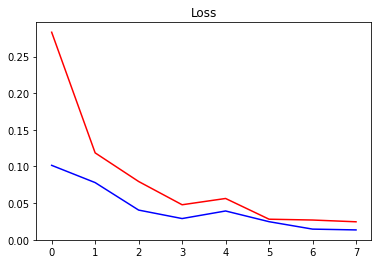

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

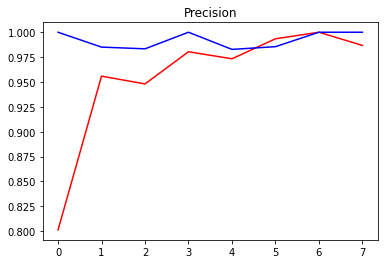

In [31]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

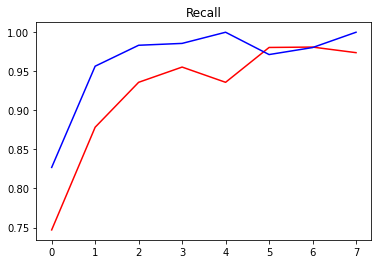

In [32]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [33]:
X_test, y_test = test.as_numpy_iterator().next()

In [35]:
yhat = cnn_model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [36]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [37]:
yhat

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [38]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [39]:
mp3 = os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', 'recording_00.mp3')

In [40]:
wav = load_mp3_16k_mono(mp3)

In [41]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [42]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [43]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [44]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [46]:
yhat = cnn_model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [48]:
from itertools import groupby

In [49]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [50]:
calls

5

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [52]:
results = {}
for file in os.listdir(os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings')):
    FILEPATH = os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = cnn_model.predict(audio_slices)
    
    results[file] = yhat

In [53]:
results

{'recording_76.mp3': array([[9.54489172e-01],
        [2.63661537e-02],
        [7.74045646e-01],
        [7.51209259e-01],
        [3.25161368e-01],
        [7.69161165e-01],
        [7.79531658e-01],
        [5.47568560e-01],
        [5.99730253e-01],
        [8.70952249e-01],
        [6.52834833e-01],
        [7.56143928e-01],
        [8.81866038e-01],
        [4.01806444e-01],
        [4.71040726e-01],
        [8.46285522e-01],
        [8.03937912e-01],
        [7.25034416e-01],
        [1.46742940e-01],
        [2.31036116e-04],
        [1.13687967e-03],
        [3.43362044e-05],
        [2.64742674e-04],
        [2.64710368e-04],
        [5.19768917e-04],
        [8.18013632e-07],
        [3.73361161e-07],
        [7.88672114e-05],
        [6.98703980e-06],
        [4.63492965e-04],
        [1.10524905e-08],
        [1.32969049e-08],
        [9.64779794e-01],
        [1.11173449e-06],
        [7.07748579e-04],
        [9.97187011e-03],
        [8.98616122e-07],
        [5.8814229

## 10.2 Convert Predictions into Classes

In [54]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_76.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0],
 'recording_62.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_48.mp3': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_44.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [55]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_76.mp3': 3,
 'recording_62.mp3': 0,
 'recording_48.mp3': 3,
 'recording_44.mp3': 0,
 'recording_45.mp3': 3,
 'recording_06.mp3': 5,
 'recording_43.mp3': 3,
 'recording_68.mp3': 1,
 'recording_95.mp3': 3,
 'recording_17.mp3': 3,
 'recording_65.mp3': 4,
 'recording_74.mp3': 1,
 'recording_10.mp3': 2,
 'recording_49.mp3': 0,
 'recording_15.mp3': 1,
 'recording_37.mp3': 3,
 'recording_64.mp3': 2,
 'recording_39.mp3': 2,
 'recording_04.mp3': 3,
 'recording_28.mp3': 4,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 3,
 'recording_12.mp3': 3,
 'recording_59.mp3': 4,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 1,
 'recording_86.mp3': 4,
 'recording_47.mp3': 3,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 25,
 'recording_51.mp3': 3,
 'recording_35.mp3': 0,
 'recording_81.mp3': 3,
 'recording_30.mp3': 1,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recording_46.

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])